In [1]:
# IMPORTING LIBRAIRIES
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser
from astropy.io import fits
from psfao21.psfao21 import psfao21
from psfFitting.psfFitting import psfFitting
import fourier.FourierUtils as FourierUtils
from fourier.fourierModel import fourierModel
from astropy.table import Table
import os

mpl.rcParams['font.size'] = 22
usetex = True
plt.rcParams.update({
    "text.usetex": usetex,
    "font.family": "serif",
    "font.serif": ["Palatino"],
}) 
path_filter = '/home/omartin/Projects/PRIME/PUAKO/CODES/EXT/_nirc2/nirc2/filters/'

In [2]:
def getScale(hdr):
    # Setup NIRC2 plate scales
    scales = {"narrow": 9.942,
              "medium": 19.829,
              "wide": 39.686}

    return scales[hdr['CAMNAME']]  

def getPA(hdr):
    return float(hdr['ROTPOSN']) - float(hdr['INSTANGL'])

def getCentralWavelength(hdr):
    return float(hdr['CENWAVE'])

def get_filter_profile(path_filter,filter):
    """
    Returns the wavelength (in microns) and the transmission for 
    the specified NIRC2 filter.

    Example: 
    (wave, trans) = nirc2.photometry.get_filter_profile('Kp')
    py.clf()
    py.plot(wave, trans)
    py.xlabel('Wavelength (microns)')
    py.ylabel('Transmission')
    """
    filters = ['J', 'H', 'K', 'Kcont', 'Kp', 'Ks', 'Lp', 'Ms',
               'Hcont', 'Brgamma', 'FeII']

    if filter not in filters:
        print( 'Could not find profile for filter %s.' % filter)
        print( 'Choices are: ', filters)
        return

    table = Table.read(path_filter + filter + '.dat', format='ascii')

    wavelength = table[table.colnames[0]]
    transmission = table[table.colnames[1]]

    # Lets fix wavelength array for duplicate values
    diff = np.diff(wavelength)
    idx = np.where(diff <= 0)[0]
    wavelength[idx+1] += 1.0e-7

    # Get rid of all entries with negative transmission
    idx = np.where(transmission > 1)[0]
    wavelength = wavelength[idx]
    transmission = transmission[idx] / 100.0 # convert from % to ratio

    return (wavelength, transmission)

In [3]:
#IMPORTING DATA
path_data = '/home/omartin/Projects/P3/data/IMAGE_KECK_Kp_c0155.fits'
im = fits.getdata(path_data)
hdr = fits.getheader(path_data)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


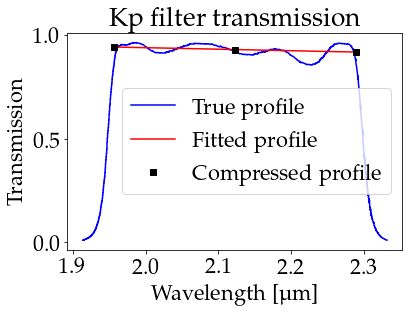

In [4]:
#GRABBING PARAMETERS FROM HEADER
#telescope status
airmass = float(hdr['AIRMASS'])
nirc2PA = getPA(hdr)
psInMas = getScale(hdr)

# spectral transmission 
# reading the .dat file
(wvl_all,tr_all)= get_filter_profile(path_filter,hdr['FWINAME'])
# fitting the transmission curve
id_f    = tr_all > 0.9*tr_all.max()
tr_f    = tr_all[id_f]
wvl_f   = wvl_all[id_f]
# linear regression
p       = np.polyfit(wvl_f,tr_f,1)
tr_f    = np.polyval(p,wvl_f)

# compressing the profile for PSF fitting; more bins means longer PSF model computation
nWvl    = 3
wvl    = wvl_f.mean()
wvlMin = wvl_f.min()
wvlMax = wvl_f.max()
bw     = wvlMax - wvlMin
wvl_c  = np.linspace(wvlMin,wvlMax,nWvl)
tr_c   = np.polyval(p,wvl_c)

# plotting
plt.figure()
plt.plot(wvl_all,tr_all,'b',label='True profile')
plt.plot(wvl_f,tr_f,'r',label='Fitted profile')
plt.plot(wvl_c,tr_c,'ks',label='Compressed profile')
plt.xlabel('Wavelength [µm]')
plt.ylabel('Transmission')
plt.title(hdr['FWINAME']+' filter transmission')
plt.legend()

In [18]:
# FITTING
# Number of pixels to crop the PSF
nPix = 300
#update the ini file
path_ini = '/home/omartin/Projects/P3/parFiles/nirc2.ini'
parser = ConfigParser()
parser.optionxform = str
parser.read(path_ini)

parser.set('PSF_DIRECTIONS','ScienceWavelength',str([wvl*1e-6]))
parser.set('PSF_DIRECTIONS','psf_FoV',str(nPix))
parser.set('PSF_DIRECTIONS','psInMas',str(psInMas))
parser.set('POLYCHROMATISM','spectralBandwidth',str(bw*1e-6))
parser.set('POLYCHROMATISM','dispersion',str(list(np.zeros(nWvl))))
parser.set('POLYCHROMATISM','transmittance',str(list(tr_c)))
    
#managing the static aberrations model
statPath = '/home/omartin/Projects/APPLY/DATA/STATIC/'
pathStat = statPath+'keck_piston_waffle_modes_200px.fits'
if not os.path.isfile(pathStat):
    waffle   = fits.getdata(statPath+'keck_waffle_200px.fits')
    waffle   = waffle/np.std(waffle[waffle>0])
    piston   = fits.getdata(statPath+'keck_piston_modes_200px.fits')
    modes    = np.concatenate((piston,waffle.reshape(200**2,1)),axis=1)
    hdu      = fits.PrimaryHDU(modes.reshape(200,200,37))
    hdu.writeto(pathStat)

with open(path_ini, 'w') as configfile:
    parser.write(configfile)
    
#instantiating the model
psfao    = psfao21(path_ini)

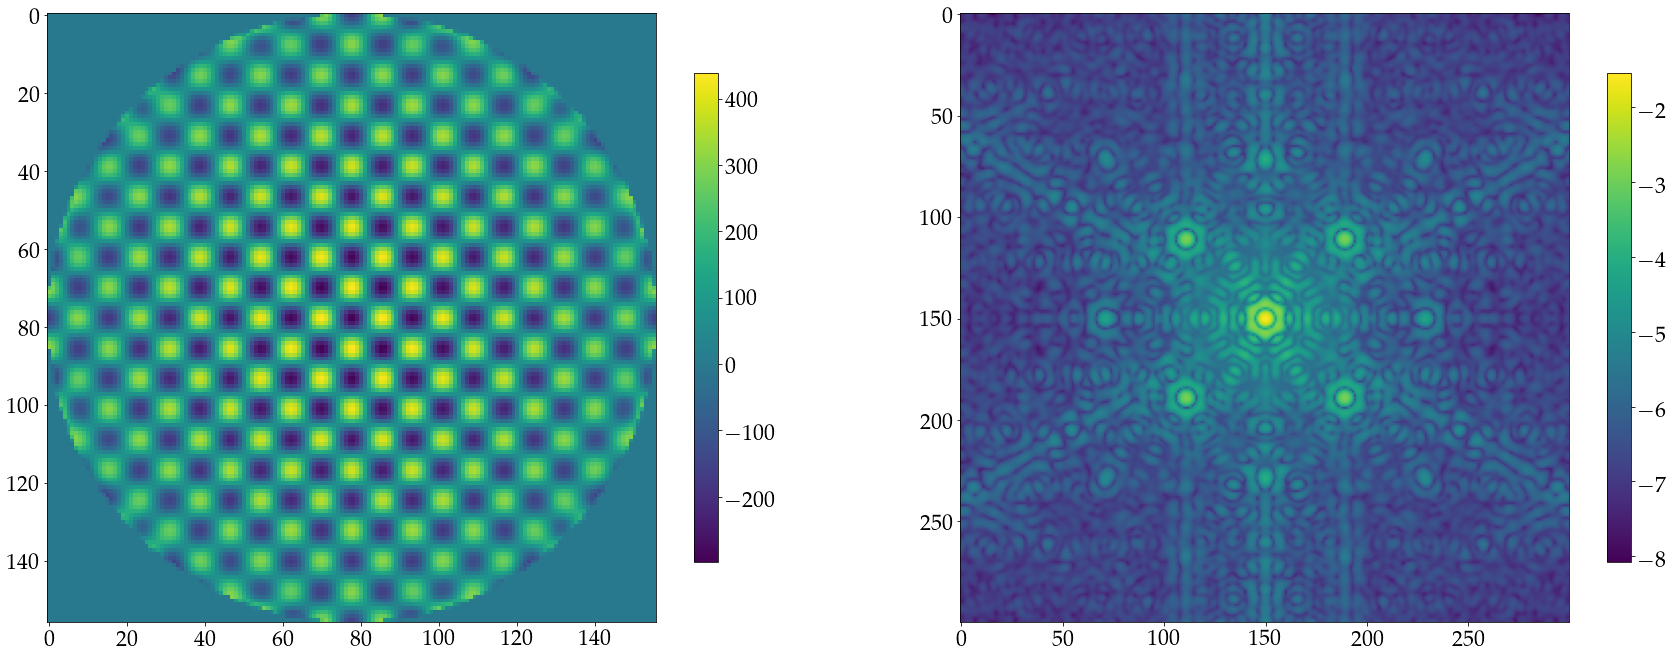

In [19]:
# check the model
xstat = np.random.randn(37)*500
xstat = np.zeros(37)
xstat[-1] = 100
x0    = [0,4e-3,0,1e-2,1,0,1.7,0,0,0,1,0,0,0] + list(xstat)
psf   = psfao(x0)
opdMap= psfao.phaseMap*psfao.wvlRef*1e9/2/np.pi

fig , axs = plt.subplots(1,2,figsize=(30,30))
pcm = axs[0].imshow(opdMap)
fig.colorbar(pcm,ax=axs[0],shrink=0.3)
pcm = axs[1].imshow(np.log10(psf))
fig.colorbar(pcm,ax=axs[1],shrink=0.3)

In [17]:
psfao.nWvl

1